# Testing 100 Day Moving Average Strategy

### Libraries Setup & Initial Plot 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
df = yf.download('^GSPC','2020-01-01')
df['MA'] = df['Adj Close'].rolling(100).mean()
df['Price'] = df['Open'].shift(-1) #if today closes above the MA then the earliest I can react is the next day's Opening price
df.dropna(inplace= True)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA,Price
Date,,,,,,,,
2020-05-26,3004.080078,3021.719971,2988.169922,2991.770020,2991.770020,5848500000,2967.473689,3015.649902
2020-05-27,3015.649902,3036.250000,2969.750000,3036.129883,3036.129883,6398000000,2965.256487,3046.610107
2020-05-28,3046.610107,3068.669922,3023.399902,3029.729980,3029.729980,5447020000,2963.205286,3025.169922
2020-05-29,3025.169922,3049.169922,2998.610107,3044.310059,3044.310059,7297550000,2961.185586,3038.780029
2020-06-01,3038.780029,3062.179932,3031.540039,3055.729980,3055.729980,4684170000,2959.371086,3064.780029
...,...,...,...,...,...,...,...,...
2024-07-19,5543.370117,5557.500000,5497.040039,5505.000000,5505.000000,3760570000,5272.013506,5544.540039
2024-07-22,5544.540039,5570.359863,5529.040039,5564.410156,5564.410156,3375180000,5276.875806,5565.299805
2024-07-23,5565.299805,5585.339844,5550.899902,5555.740234,5555.740234,3500210000,5281.735610,5505.839844


<Axes: xlabel='Date'>

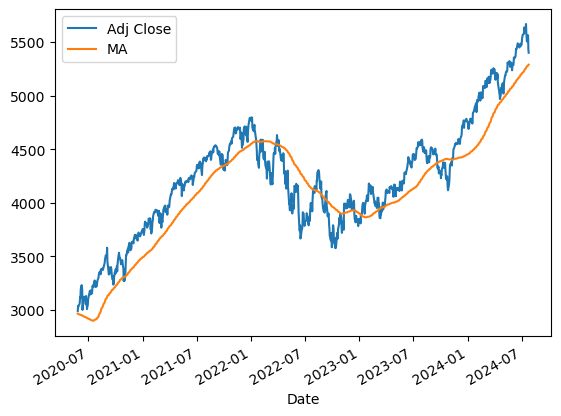

In [3]:
df[['Adj Close','MA']].plot()

### Stategy Operation: Determining The signals and indexing buy and sell prices

In [4]:
buy, sell, buydate, selldate = [],[],[],[]

in_position = False         #initialise position false. i.e. start with no trade

for index, rows in df.iterrows():
    if not in_position and rows['Close'] > rows['MA']:  #no flips the condition of the and so that it triggers when position is in false. i.e. when youre not currently in a position send a buy signal
        buy.append(rows['Price'])
        buydate.append(rows.name)
        in_position = True 
    if in_position and rows['Close'] < rows['MA']:
       sell.append(rows['Price'])
       selldate.append(rows.name)
       in_position = False
if in_position:                 #self closing. i.e. if you are in an open posiiton at the time of backtesting, close it at the most recent market price.
    sell.append(rows['Price'])
    selldate.append(rows.name)

len(buy),len(sell),len(buydate),len(selldate)

(19, 19, 19, 19)

In [5]:
#we could also solve the self closing issue like this

#sell.append(df['Open'].iloc[-1])
#sell, len(buy),len(sell)

### Strategy Buy and Sell Signal Data Frame

In [6]:
x = pd.DataFrame({'Buy Date':buydate,
                  'Sell Date':selldate,
                  'Enter':buy,
                  'Exit':sell,
                  })
x


,Buy Date,Sell Date,Enter,Exit
0,2020-05-26,2020-10-28,3015.649902,3277.169922
1,2020-10-29,2020-10-30,3293.590088,3296.199951
2,2020-11-03,2021-09-30,3406.459961,4317.160156
3,2021-10-01,2021-10-04,4348.839844,4309.870117
4,2021-10-06,2021-10-12,4383.729980,4358.009766
5,2021-10-14,2022-01-19,4447.689941,4547.350098
6,2022-02-02,2022-02-03,4535.410156,4482.790039
7,2022-02-09,2022-02-10,4553.240234,4506.270020
8,2022-03-28,2022-03-31,4602.859863,4540.319824
9,2022-04-01,2022-04-05,4547.970215,4494.169922


### Strategy Performance Summary
    - Return on each Trade
    - Cumulative Return and Plot
    - Expected Return, Standard Deviation, Sharpe Ratio

    Learnt to change the order of the columns in a DF here

In [7]:
x['Return']= (x['Exit'] / x['Enter'])-1
x['CumRet']= (x['Return']+1).cumprod()-1
x['Duration of Holding'] = x['Sell Date'] - x['Buy Date']

new_order = ['Buy Date', 'Sell Date', 'Duration of Holding', 'Enter', 'Exit', 'Return', 'CumRet',]
x = x[new_order]
x

,Buy Date,Sell Date,Duration of Holding,Enter,Exit,Return,CumRet
0,2020-05-26,2020-10-28,155 days,3015.649902,3277.169922,0.086721,0.086721
1,2020-10-29,2020-10-30,1 days,3293.590088,3296.199951,0.000792,0.087582
2,2020-11-03,2021-09-30,331 days,3406.459961,4317.160156,0.267345,0.378342
3,2021-10-01,2021-10-04,3 days,4348.839844,4309.870117,-0.008961,0.365991
4,2021-10-06,2021-10-12,6 days,4383.729980,4358.009766,-0.005867,0.357976
5,2021-10-14,2022-01-19,97 days,4447.689941,4547.350098,0.022407,0.388404
6,2022-02-02,2022-02-03,1 days,4535.410156,4482.790039,-0.011602,0.372296
7,2022-02-09,2022-02-10,1 days,4553.240234,4506.270020,-0.010316,0.358140
8,2022-03-28,2022-03-31,3 days,4602.859863,4540.319824,-0.013587,0.339686
9,2022-04-01,2022-04-05,4 days,4547.970215,4494.169922,-0.011830,0.323839


Expected Return:2.81%, Standard Deviation:8.51%, Sharpe Ratio:0.33


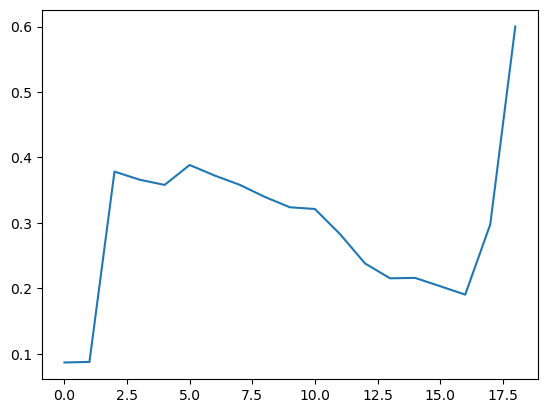

In [8]:
x['CumRet'].plot()

Expected_Return = x['Return'].mean()
Standard_Deviation = x['Return'].std()
Sharpe_Ratio = Expected_Return / Standard_Deviation

print(f'Expected Return:{round(Expected_Return*100,2)}%, Standard Deviation:{round((Standard_Deviation*100),2)}%, Sharpe Ratio:{round(Sharpe_Ratio,3)}')

### My attempt at plotting SNP500 cumualtive returns against the Strategy's

<Axes: xlabel='Date'>

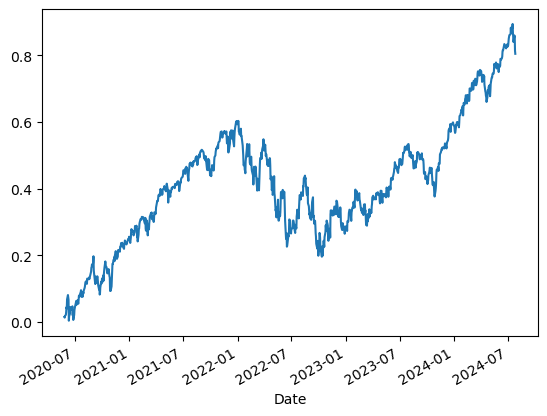

In [9]:
((df['Adj Close'].pct_change()+1).cumprod()-1).plot()

In [10]:
y = pd.concat([df,x],axis = 0)
y['snpcumret'] = (y['Adj Close'].pct_change()+1).cumprod()-1
y

,Open,High,Low,Close,Adj Close,Volume,MA,Price,Buy Date,Sell Date,Duration of Holding,Enter,Exit,Return,CumRet,snpcumret
2020-05-26 00:00:00,3004.080078,3021.719971,2988.169922,2991.770020,2991.770020,5.848500e+09,2967.473689,3015.649902,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN
2020-05-27 00:00:00,3015.649902,3036.250000,2969.750000,3036.129883,3036.129883,6.398000e+09,2965.256487,3046.610107,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.014827
2020-05-28 00:00:00,3046.610107,3068.669922,3023.399902,3029.729980,3029.729980,5.447020e+09,2963.205286,3025.169922,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.012688
2020-05-29 00:00:00,3025.169922,3049.169922,2998.610107,3044.310059,3044.310059,7.297550e+09,2961.185586,3038.780029,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.017562
2020-06-01 00:00:00,3038.780029,3062.179932,3031.540039,3055.729980,3055.729980,4.684170e+09,2959.371086,3064.780029,NaT,NaT,NaT,NaN,NaN,NaN,NaN,0.021379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-06,2023-03-09,62 days,3910.820068,3912.770020,0.000499,0.215920,0.804691
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-16,2023-03-17,1 days,3958.689941,3917.469971,-0.010413,0.203259,0.804691
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-21,2023-03-22,1 days,4002.040039,3959.209961,-0.010702,0.190382,0.804691
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-24,2023-09-21,181 days,3982.929932,4341.740234,0.090087,0.297620,0.804691


In [11]:
# ???
#((df['Adj Close'].pct_change()+1).cumprod()-1).plot(), x['CumRet'].plot()

<Axes: xlabel='Date'>

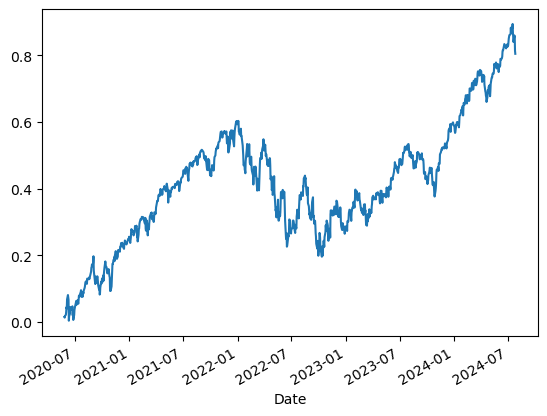

In [12]:
((df['Adj Close'].pct_change()+1).cumprod()-1).plot()